# Missing Values

In [29]:
import pandas as pd
import missingno as msno

In [30]:
df = pd.read_csv("datasets/diabetes.csv")

<AxesSubplot: >

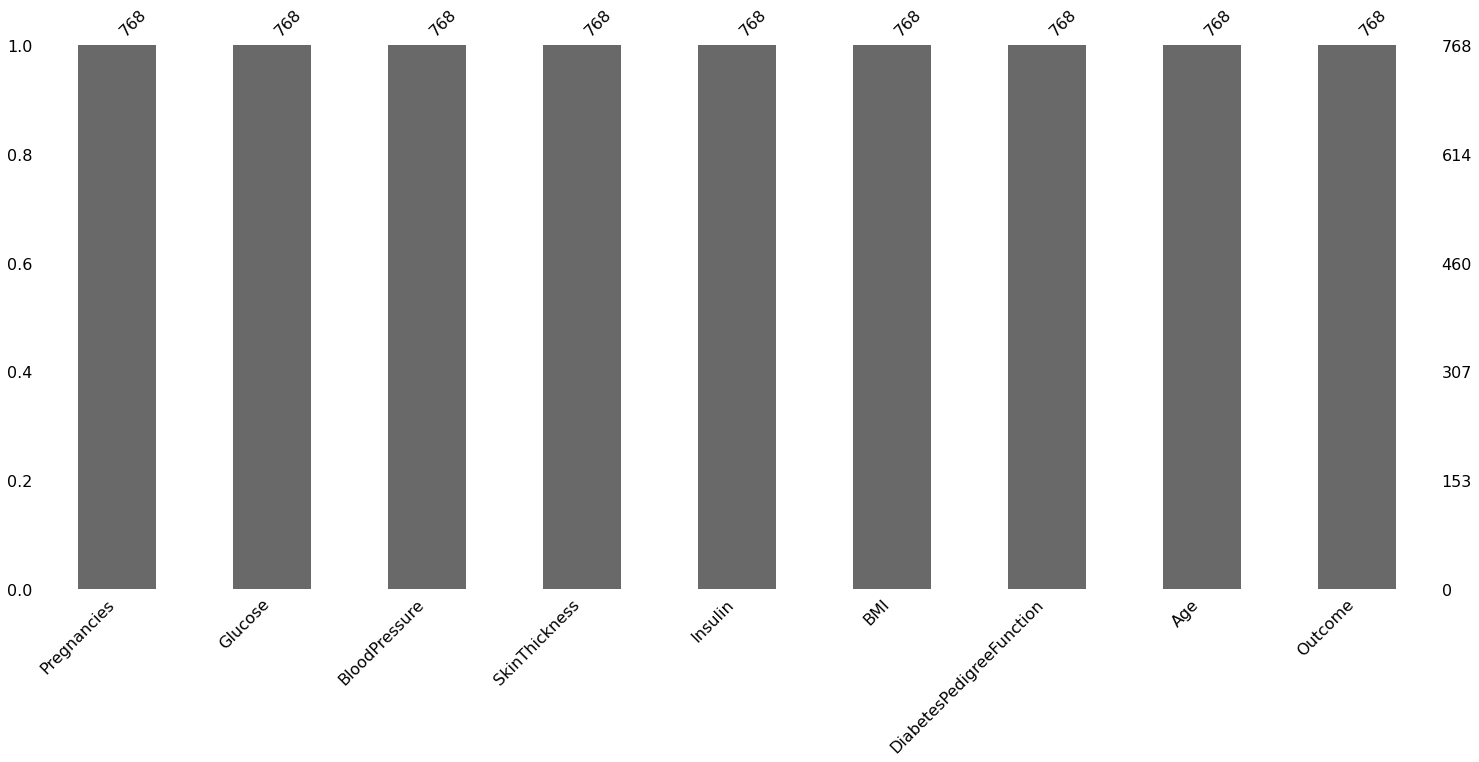

In [31]:
msno.bar(df)

<AxesSubplot: >

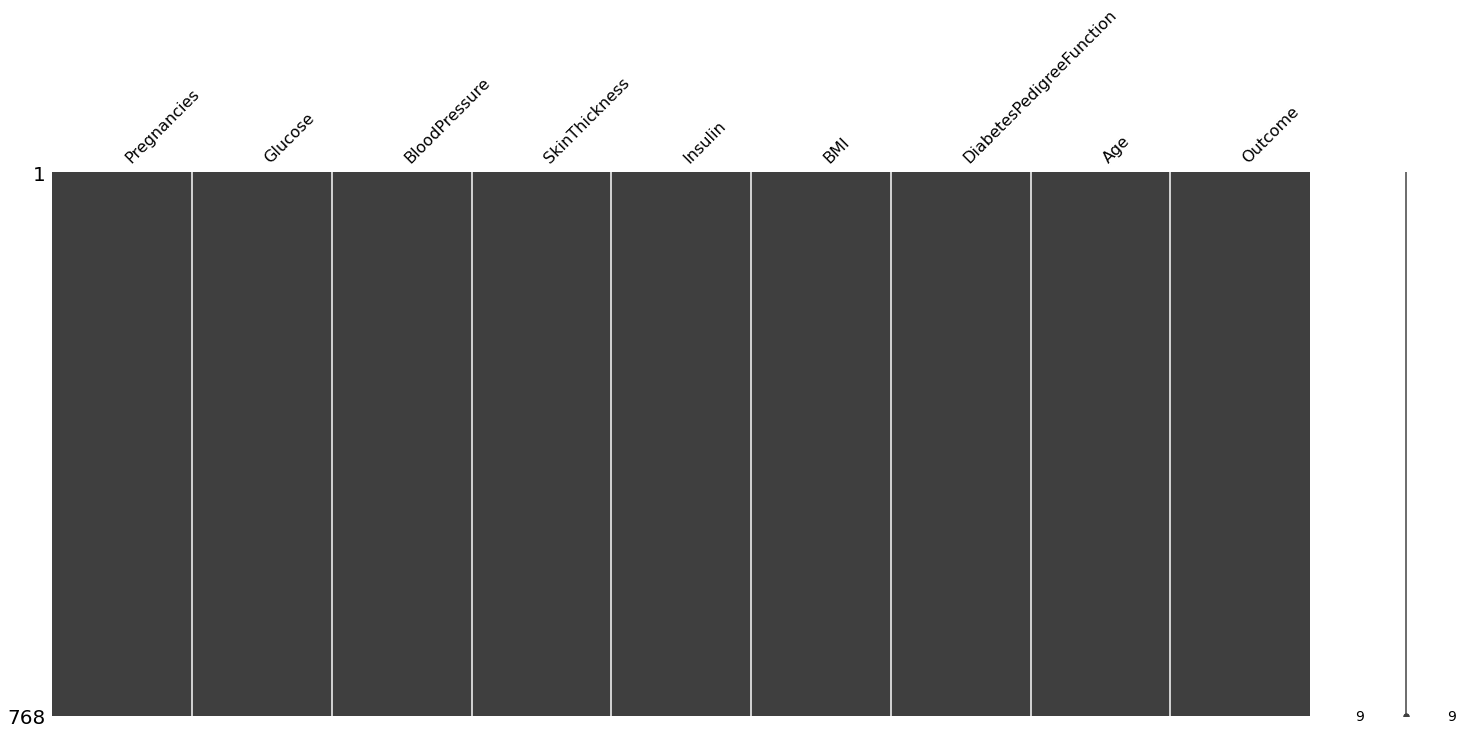

In [32]:
msno.matrix(df)

Until now there is no missing value in diabetes dataset. It has got 768 rows however can to look heatmap and dendrogram graphs.
## Determining Missing Values

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Select to filled missing values for described data. As known, such as *Pregnancies can be zero but Glucose cannot be zero.*. For the Biology:
- Glucose
- Blood Pressure
- Skin Thinkness
- Insulin
- BMI

cannot be zero. Replace **zero with NaN** value.

In [34]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [35]:
missing_df = df[missing_columns]

In [36]:
missing_df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148,72,35,0,33.6
1,85,66,29,0,26.6
2,183,64,0,0,23.3
3,89,66,23,94,28.1
4,137,40,35,168,43.1


In [37]:
missing_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,120.894531,31.972618,0.0,99.0,117.0,140.25,199.0
BloodPressure,768.0,69.105469,19.355807,0.0,62.0,72.0,80.00,122.0
SkinThickness,768.0,20.536458,15.952218,0.0,0.0,23.0,32.00,99.0
Insulin,768.0,79.799479,115.244002,0.0,0.0,30.5,127.25,846.0
BMI,768.0,31.992578,7.884160,0.0,27.3,32.0,36.60,67.1


In [38]:
import numpy as np

In [39]:
missing_df.replace(0, np.nan, inplace=True)

C:\Users\talha\AppData\Local\Temp\ipykernel_13832\2579228047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df.replace(0, np.nan, inplace=True)


In [40]:
missing_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Glucose,763.0,121.686763,30.535641,44.0,99.00,117.0,141.0,199.0
BloodPressure,733.0,72.405184,12.382158,24.0,64.00,72.0,80.0,122.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.00,29.0,36.0,99.0
Insulin,394.0,155.548223,118.775855,14.0,76.25,125.0,190.0,846.0
BMI,757.0,32.457464,6.924988,18.2,27.50,32.3,36.6,67.1


## Analyze the Missing Values

In [126]:
from feature_utils import get_null_summary

2023-03-12 02:10:10,808 - logging_utils - DEBUG - get_null_summary executing...
2023-03-12 02:10:10,814 - logging_utils - INFO - 
               null  not-null
Glucose           5       763
BloodPressure    35       733
SkinThickness   227       541
Insulin         374       394
BMI              11       757


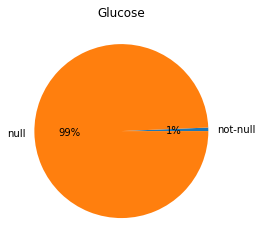

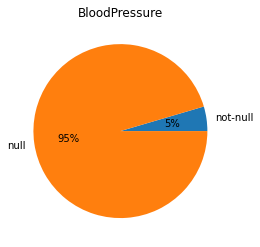

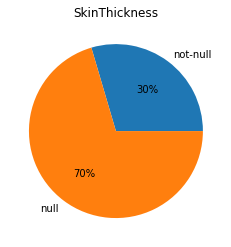

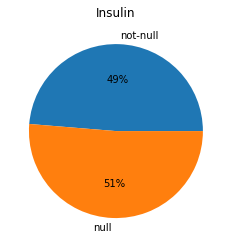

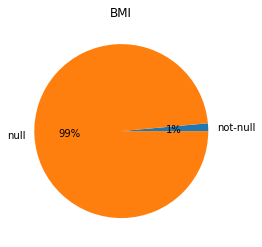

In [127]:
get_null_summary(missing_df, 1)

As the seen above, *Insulin and SkinThickness* have got too missing values.

<AxesSubplot: >

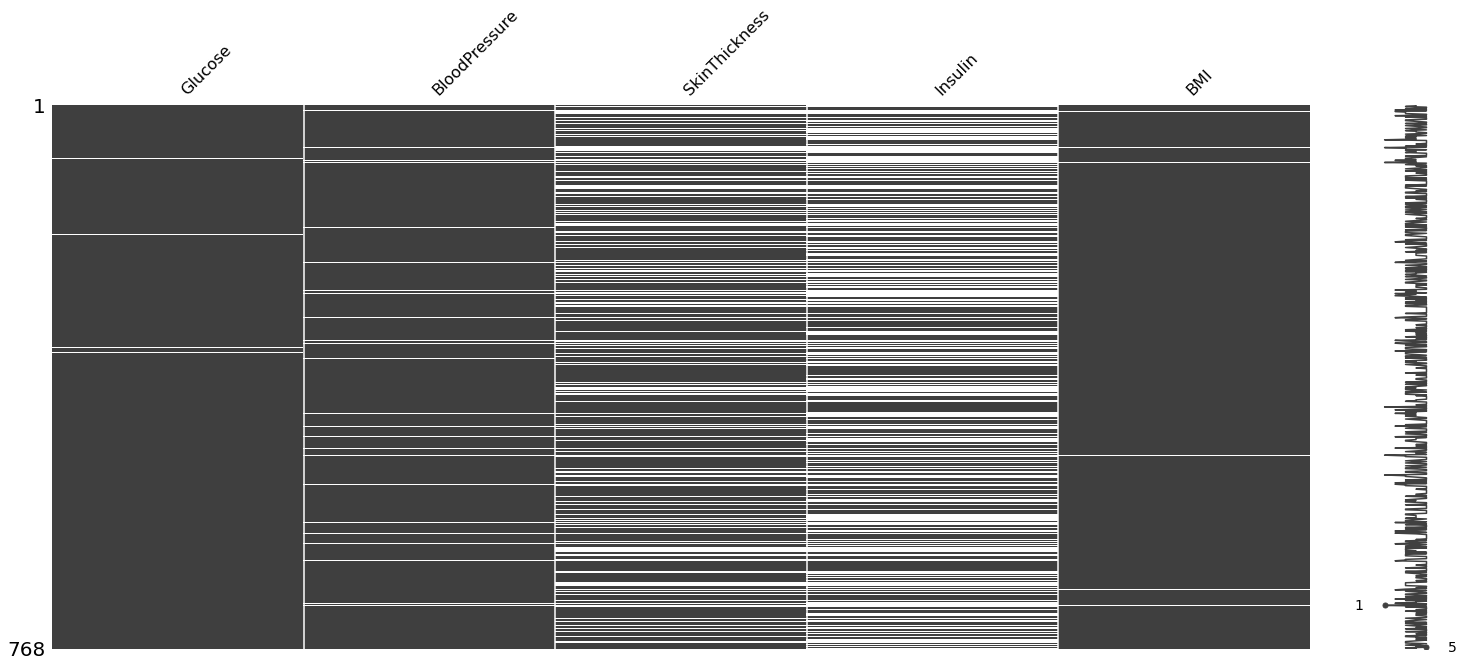

In [128]:
msno.matrix(missing_df)

<AxesSubplot: >

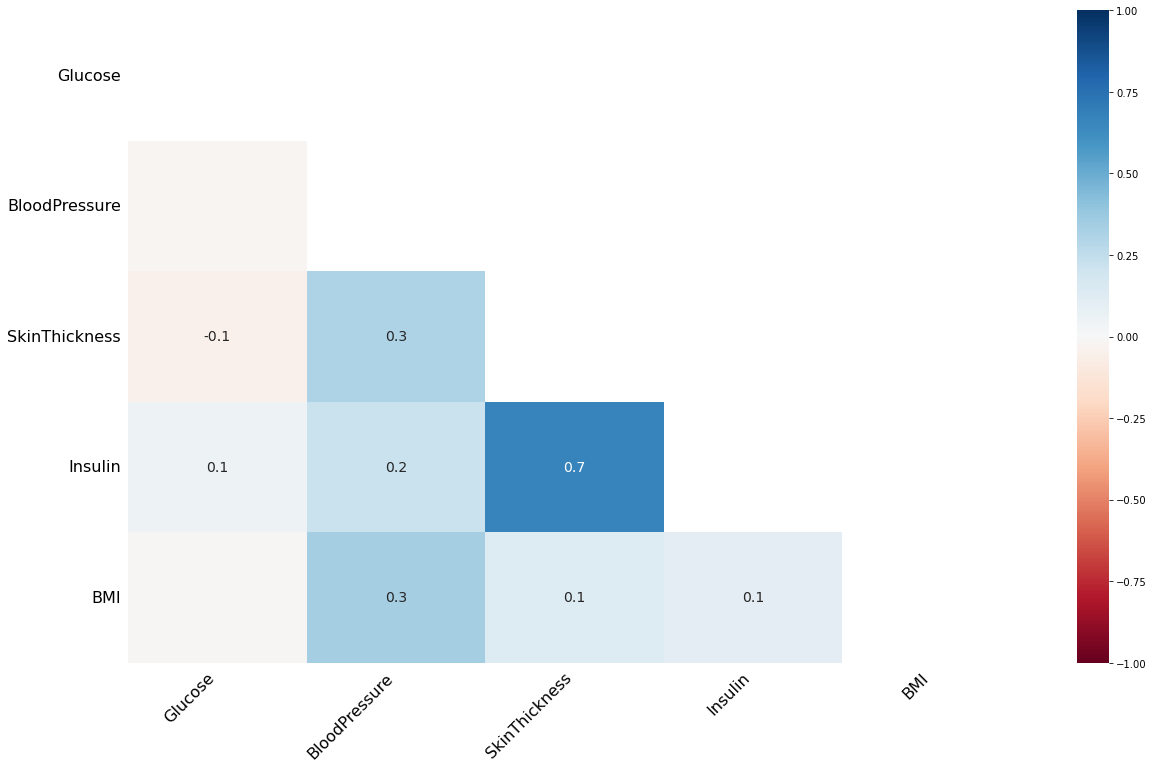

In [129]:
msno.heatmap(missing_df)

<AxesSubplot: >

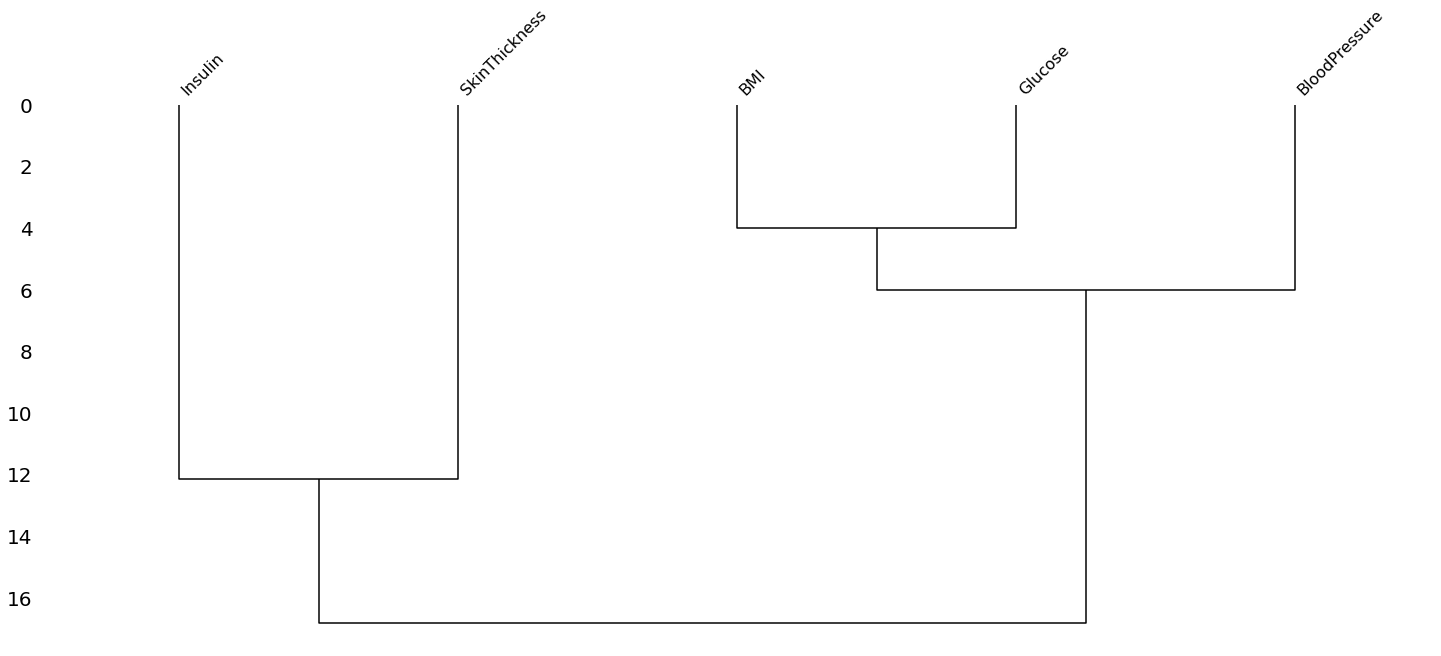

In [130]:
msno.dendrogram(missing_df)

**Analyze Result:**
1. Insulin and SkinThickness dependent each other. (12)
2. BMI and Glucose dependent each other. (4)
3. (BMI + Glucose) and BloodPressure dependent each other. (6)

## Filling the Missing Values

For the filling missing values, there are several options:
* Fill with zero.
* Fill with average or median.
* Fill with prediction.

Try to all options

## Fill with Prediction

In [22]:
from pyspark.sql import SparkSession, functions as F
import findspark

findspark.init("C:\Program Files\Spark\spark-3.3.1-bin-hadoop3")

In [23]:
spark = SparkSession.builder \
    .appName("Diabetes Classification") \
    .master("local[2]") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

### Create Model
#### Scale Data

In [41]:
from sklearn.preprocessing import RobustScaler

In [42]:
scaler = RobustScaler()

In [43]:
transformer = scaler.fit_transform(missing_df)

In [44]:
scaled_df = pd.DataFrame(transformer, columns=missing_df.columns)

In [45]:
from sklearn.impute import KNNImputer

In [303]:
def knn_tunning(range_,
                scaler,
                evaluator,
                scaled_df: pd.DataFrame, 
                original_df: pd.DataFrame) -> list:
    
    scores = []
    
    for x in range(2, range_):
        temp_df = original_df.copy()

        imputer = KNNImputer(n_neighbors=x)
        imputed_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns=scaled_df.columns)

        filled_df = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=imputed_df.columns)

        temp_df[filled_df.columns] = filled_df

        scores.append((x, get_score(temp_df, evaluator)))
        
    return scores

In [306]:
tune_list = knn_tunning(30, scaler, evaluator, scaled_df, pd.read_csv("datasets/diabetes.csv"))

C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is dep

In [311]:
tune_list = np.array(tune_list)

In [325]:
tune_list

array([[ 2.        ,  0.85109386],
       [ 3.        ,  0.83368274],
       [ 4.        ,  0.81918239],
       [ 5.        ,  0.81848358],
       [ 6.        ,  0.84233299],
       [ 7.        ,  0.80702665],
       [ 8.        ,  0.83001715],
       [ 9.        ,  0.82144082],
       [10.        ,  0.79227813],
       [11.        ,  0.8317757 ],
       [12.        ,  0.83021807],
       [13.        ,  0.81621244],
       [14.        ,  0.84032145],
       [15.        ,  0.8431167 ],
       [16.        ,  0.84302527],
       [17.        ,  0.83752621],
       [18.        ,  0.82848737],
       [19.        ,  0.80957372],
       [20.        ,  0.83506404],
       [21.        ,  0.83575632],
       [22.        ,  0.82571824],
       [23.        ,  0.84146764],
       [24.        ,  0.83246798],
       [25.        ,  0.8283143 ],
       [26.        ,  0.79837314],
       [27.        ,  0.83627553],
       [28.        ,  0.85946694],
       [29.        ,  0.83731395]])

In [324]:
tune_list[:, 1].max()

0.8594669435790931

This is 28. n_neighbors.

In [317]:
tune_list.max(axis=1)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29.])

#### Impute Data

In [46]:
imputer = KNNImputer(n_neighbors=28)

In [47]:
imputed_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns=scaled_df.columns)

In [48]:
imputed_df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738095,0.000,0.428571,0.677237,0.142857
1,-0.761905,-0.375,0.000000,-0.349137,-0.626374
2,1.571429,-0.500,-0.272959,0.881319,-0.989011
3,-0.666667,-0.375,-0.428571,-0.272527,-0.461538
4,0.476190,-2.000,0.428571,0.378022,1.186813


Filled data cannot understandable now. Lets inverse to data.

In [49]:
filled_df = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=imputed_df.columns)

In [50]:
filled_df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.000000,202.035714,33.6
1,85.0,66.0,29.000000,85.285714,26.6
2,183.0,64.0,25.178571,225.250000,23.3
3,89.0,66.0,23.000000,94.000000,28.1
4,137.0,40.0,35.000000,168.000000,43.1


In [51]:
prediction_df = df.copy()

In [52]:
prediction_df[filled_df.columns] = filled_df

## Fill with Average

In [53]:
df[missing_df.columns] = missing_df

In [54]:
avg_df = df.copy()

In [55]:
for col in avg_df.columns:
    query = avg_df.groupby("Outcome")[col].mean()
    
    avg_df[avg_df["Outcome"] == 0].loc[avg_df[col].isnull(), col] = query[0]
    avg_df[avg_df["Outcome"] == 1].loc[avg_df[col].isnull(), col] = query[1]

In [56]:
avg_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## Fill with Median

In [57]:
median_df = df.copy()

In [58]:
for col in median_df.columns:
    query = median_df.groupby("Outcome")[col].median()
    
    median_df[median_df["Outcome"] == 0].loc[median_df[col].isnull(), col] = query[0]
    median_df[median_df["Outcome"] == 1].loc[median_df[col].isnull(), col] = query[1]

In [59]:
median_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## Comparing with Machine Learning Model

In [60]:
from ml_utils import *
from pyspark.ml.classification import GBTClassifier

assembler = set_assembler(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])

scaler = set_scaler()

estimator = GBTClassifier() \
    .setFeaturesCol("features") \
    .setLabelCol("Outcome")

pipeline_obj = set_pipeline(False, [assembler, scaler, estimator])

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Outcome")

In [62]:
def get_score(df, evaluator):
    spark_df = spark.createDataFrame(df)
    
    train_df, test_df = spark_df.randomSplit([.8, .2], seed=142)
    
    pipeline_model = pipeline_obj.fit(train_df)
    transformed_df = pipeline_model.transform(test_df)
    
    return evaluator.evaluate(transformed_df)

### Prediction Dataframe

In [63]:
get_score(prediction_df, evaluator)

C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


0.859466943579093

### Median Dataframe

In [64]:
get_score(median_df, evaluator)

0.8349577647823262

### Average Dataframe

In [65]:
get_score(avg_df, evaluator)

0.8349577647823262

### Original Dataframe

In [66]:
get_score(pd.read_csv("datasets/diabetes.csv"), evaluator)

C:\Users\talha\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


0.8413379073756433

### Result
Understand to there prediction dataframe is the best option.

## Save Filled Dataframe

In [67]:
prediction_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.000000,3.000000,6.00000,17.00
Glucose,768.0,121.690337,30.440223,44.000,99.750000,117.000000,140.25000,199.00
BloodPressure,768.0,72.372535,12.143375,24.000,64.000000,72.000000,80.00000,122.00
SkinThickness,768.0,28.864304,9.369033,7.000,22.232143,28.732143,35.00000,99.00
Insulin,768.0,151.562826,93.117689,14.000,92.000000,135.000000,182.00000,846.00
BMI,768.0,32.446573,6.878629,18.200,27.500000,32.050000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.000000,29.000000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000000,0.000000,1.00000,1.00


In [68]:
prediction_df.to_parquet("datasets/diabets_non_null.parquet")

In [70]:
spark.stop()

Continue with **outliers jupyter file**.